In [2]:
import matplotlib
%matplotlib nbagg

# Files imported from the CSHL module with common general-purpose functions
import tdms
import imp
imp.reload(tdms)
import plot
import functions

# Python libraries that ship with your Python distribution
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/__init__.py:908: MatplotlibDeprecationWarning: The backend.qt4 rcParam was deprecated in version 2.2.  In order to force the use of a specific Qt binding, either import that binding first, or set the QT_API environment variable.
  mplDeprecation)


# Activation current-voltage relationship (I-V)

In [7]:
# data = tdms.read_tdms("/Volumes/DATA/data/tdms/D2-vc-060717-vc2-1.tdms")
# data = tdms.read_tdms("/Volumes/DATA/data/tdms/CHSL-6.8.1701-9VCLAMPNACURRENT.tdms")
# data = tdms.read_tdms("/Volumes/DATA/data/tdms/CHSL-6.8.1702-1.tdms")
data = tdms.read_tdms("/Volumes/STORE N GO/Mantis64/Voltage_Step-default-6-198669727.tdms")

In [8]:
data.keys()

['dt', 'yunits', u'AI0', 'holding', u'AO0']

In [9]:
holding = -80
erev = 20
pulsedelay = 10
pulsedur = 100

<IPython.core.display.Javascript object>


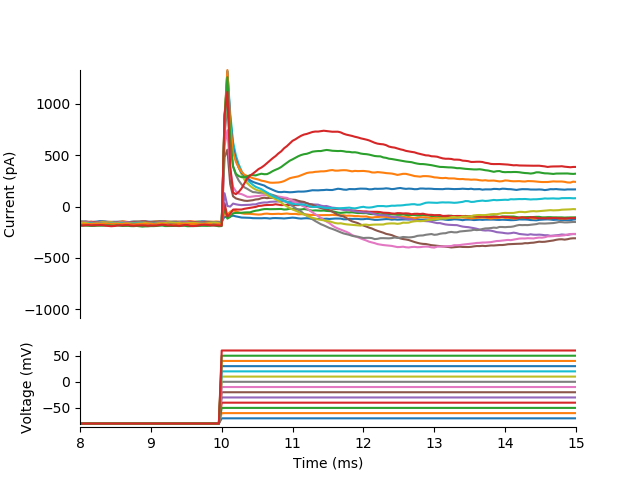

(8, 15)

In [10]:
fig, axi, axv = plot.plot_traces(mode='vclamp')
for sweep, command in zip(data['AI0'], data['AO0']): 
    times = np.arange(sweep.shape[0])*data['dt']
    axi.plot(times, sweep)
    axv.plot(times, holding + command)
axi.set_xlim(pulsedelay-2, pulsedelay+5)


<IPython.core.display.Javascript object>


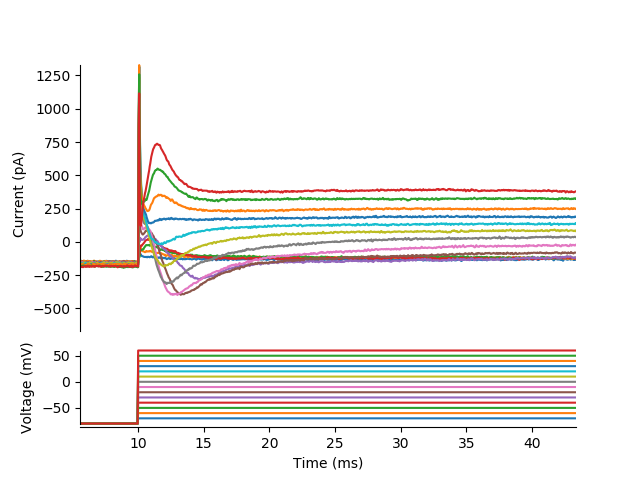

<IPython.core.display.Javascript object>


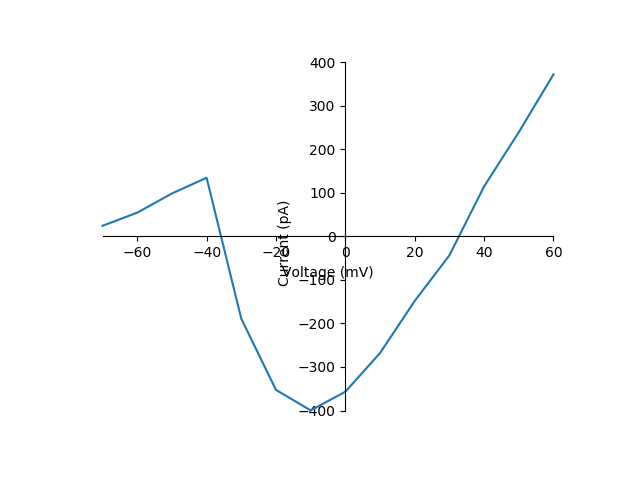

[-10.38026241   9.24669577]


<IPython.core.display.Javascript object>


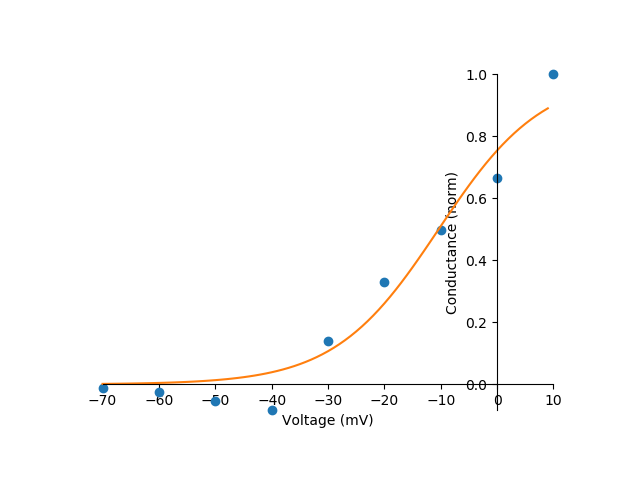

In [11]:
fig, axi, axv = plot.plot_traces(mode='vclamp')

pulses = []
peaks = []

dt = data['dt']
for sweep, command in zip(data['AI0'], data['AO0']): 
    pulsebase = np.mean(command[:int(pulsedelay/dt)])
    pulsemax = np.max(command[:int((pulsedelay+pulsedur)/dt)]-pulsebase)
    pulsemin = np.min(command[:int((pulsedelay+pulsedur)/dt)]-pulsebase)
    if np.abs(pulsemax) > np.abs(pulsemin):
        pulseamp = pulsemax+holding
    else:
        pulseamp = pulsemin+holding
    pulses.append(pulseamp)

    baseline = np.nanmean(sweep[
        int((pulsedelay+pulsedur-10)/dt):int((pulsedelay+pulsedur)/dt)])
    maxpeak = np.max(sweep[int((pulsedelay+0.9)/dt):int((pulsedelay+50.0)/dt)]-baseline)
    minpeak = np.min(sweep[int((pulsedelay+0.9)/dt):int((pulsedelay+50.0)/dt)]-baseline)
    if np.abs(minpeak) > np.abs(maxpeak):
        peaks.append(minpeak)
    else:
        peaks.append(maxpeak)
    times = np.arange(sweep.shape[0])*data['dt']
    axi.plot(times, sweep)
    axv.plot(times, holding + command)

fig, ax = plot.plot_iv()
ax.plot(pulses, peaks)

pulses = np.array(pulses)
peaks = np.array(peaks)[pulses < erev]
pulses = pulses[pulses < erev]

# Plot conductance-voltage relationship
g, gfit = functions.gv(np.array(peaks), np.array(pulses), erev)
print(gfit)
curverange = np.arange(np.min(pulses), np.max(pulses), 1.0)
curve = functions.fboltz_up(gfit, curverange)

fig, ax = plot.plot_iv(ylabel="Conductance (norm)")
ax.plot(pulses, g, 'o')
ax.plot(curverange, curve)

plt.show()

# Steady-state Nav channel fast inactivation

In [3]:
data = tdms.read_tdms("/Volumes/STORE N GO/Sofia_Ryan_Nachannels-fast-activation-1-0-614597774.tdms")

In [7]:
pulsebasedelay = 50
inactpulsedur = 500
testpulsedur = 50
holding = -80
print(data['dt'])

0.04


<IPython.core.display.Javascript object>


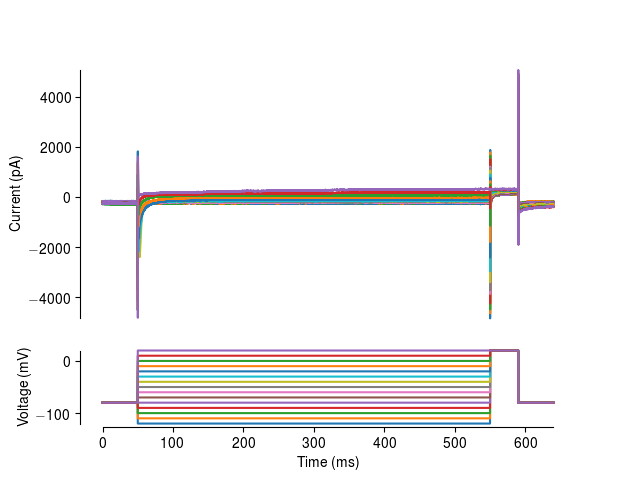

[-65.07643883 -16.67647576]


<IPython.core.display.Javascript object>


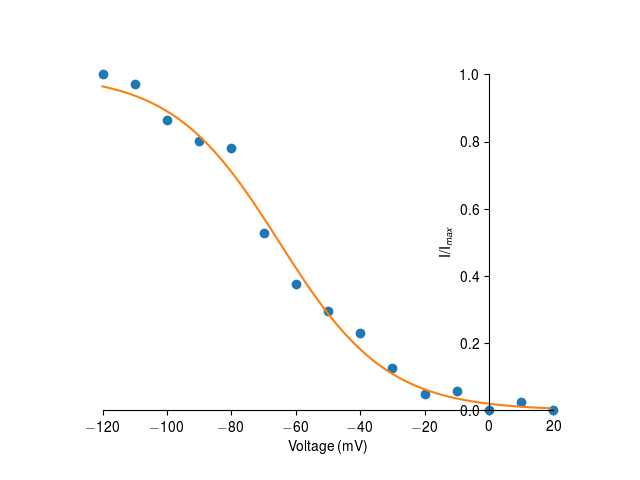

In [13]:
fig, axi, axv = plot.plot_traces(mode='vclamp')

pulses = []
peaks = []

dt = data['dt']
for sweep, command in zip(data['AI0'], data['AO0']): 
    pulsebase = np.mean(command[:int(pulsebasedelay/dt)])
    pulsemax = np.max(command[
        int((pulsebasedelay+inactpulsedur-10)/dt):
        int((pulsebasedelay+inactpulsedur)/dt)]-pulsebase)
    pulsemin = np.min(command[
        int((pulsebasedelay+inactpulsedur-10)/dt):
        int((pulsebasedelay+inactpulsedur)/dt)]-pulsebase)
    if np.abs(pulsemax) > np.abs(pulsemin):
        pulseamp = pulsemax+holding
    else:
        pulseamp = pulsemin+holding
    pulses.append(pulseamp)

    baseline = np.mean(sweep[
        int((pulsebasedelay-5)/dt):
        int((pulsebasedelay)/dt)])
    mintestpeak = np.min(sweep[
        int((pulsebasedelay+inactpulsedur+0.5)/dt):
        int((pulsebasedelay+inactpulsedur+20.0)/dt)])-baseline
    if len(pulses) == 1:
        minrefpeak = mintestpeak
    peaks.append(mintestpeak/minrefpeak)

    times = np.arange(sweep.shape[0])*data['dt']
    axi.plot(times, sweep)
    axv.plot(times, holding + command)
    
peaks = np.array(peaks)
peaks -= peaks.min()
peaks /= peaks.max()
    
# Plot conductance-voltage relationship
v50_init = 0.0
slope_init = -1.0
gfit = functions.leastsq(
    functions.leastsq_helper, (v50_init, slope_init), args=(peaks, functions.fboltz_up, pulses))[0]
print(gfit)
curverange = np.arange(np.min(pulses), np.max(pulses), 1.0)
curvefit = functions.fboltz_up(gfit, curverange)

fig, ax = plot.plot_iv(ylabel=r"I/I_{max}")
ax.plot(pulses, peaks, 'o')
ax.plot(curverange, curvefit)
ax.plot()

plt.show()    

# Recovery from inactivation

In [16]:
data = tdms.read_tdms("/Volumes/DATA/data/tdms/L5-Ina-DM-J10-C3-recoverytime.tdms")

In [17]:
pulsedelay = 10
pulsedur = 50
recovery_t0 = 0.5
recovery_dt = 0.5
holding = -80
print(data['dt'])

0.04


<IPython.core.display.Javascript object>


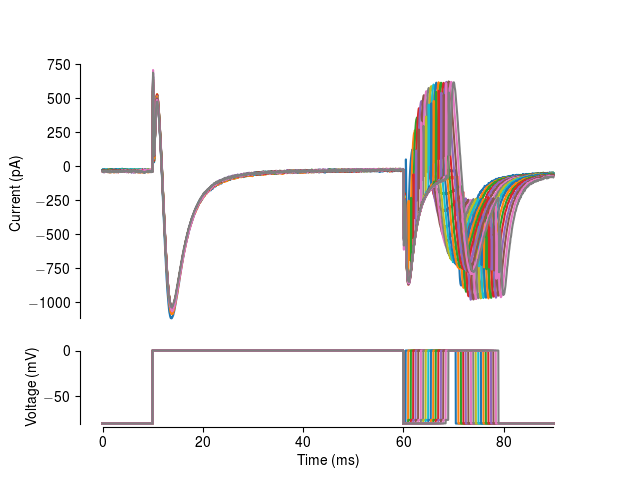

2.41079719913


<IPython.core.display.Javascript object>


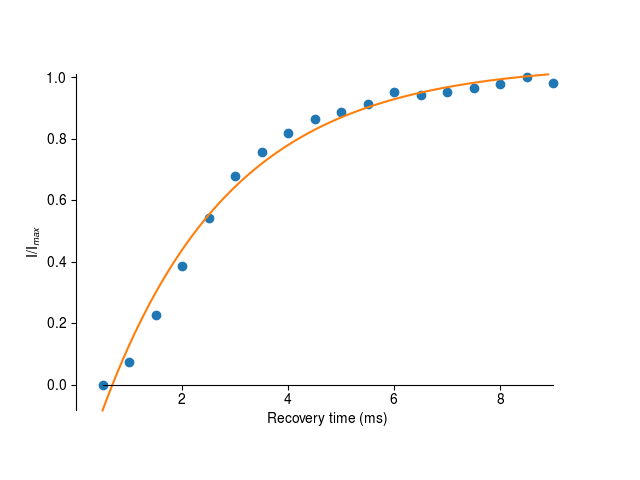

In [19]:
fig, axi, axv = plot.plot_traces(mode='vclamp')

pulses = []
peaks = []
recovery_ts = []

dt = data['dt']
recovery_t = recovery_t0
for sweep, command in zip(data['AI0'], data['AO0']):
    baseline = np.mean(sweep[:int(pulsedelay/dt)])
    minpeak = np.min(sweep[
        int((pulsedelay+pulsedur+recovery_t+4.0)/dt):
        int((pulsedelay+pulsedur+recovery_t+10.0)/dt)])
    peaks.append(minpeak)
    recovery_ts.append(recovery_t)
    
    times = np.arange(sweep.shape[0])*data['dt']
    axi.plot(times, sweep)
    axv.plot(times, holding + command)
    
    recovery_t += recovery_dt

peaks = -np.array(peaks)
peaks -= np.min(peaks)
peaks /= peaks.max()
recovery_ts = np.array(recovery_ts)

fitrange = np.arange(np.min(recovery_ts), np.max(recovery_ts), 0.1)
taufit = functions.leastsq(
    functions.leastsq_helper, (-1.0, 10.0, 1.0),
    args=(peaks, functions.fexp, recovery_ts))[0]
print(taufit[1])
plottau = functions.fexp(taufit, fitrange)

fig, ax = plot.plot_iv(xlabel='Recovery time (ms)', ylabel=r"I/I_{max}")
ax.plot(recovery_ts, peaks, 'o')
ax.plot(fitrange, plottau)

plt.show()